Analysis demo for XAI4PDF applied to phenomenological fits CT18NNLO

Brandon Kriesten (bkriesten@anl.gov), Jonathan Gomprecht, T.J. Hobbs (tim@anl.gov)

In [1]:
#Standard numerical analysis imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lhapdf
import pickle
import tqdm
import tensorflow as tf

#Import the ResNet-like model
from resnet_model import *

#Imports necessary for tensorflow model
from tensorflow.keras import models, optimizers, layers, losses, regularizers, callbacks

#Imports necessary for statistical analysis of model accuracy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Import necessary to make the plotting look nice
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

#Makes the plotting font Times
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times"
})

In [2]:
#Load test set which was not seen during training
x_test_1 = np.load("pheno_class_x_test_1.npy")
x_test_2 = np.load("pheno_class_x_test_2.npy")

x_test = np.vstack([x_test_1, x_test_2])
y_test = np.load("pheno_class_y_test.npy")

# Confusion Matrix

In [3]:
#Plot the confusion matrix of the test set
def get_conf_matrix(x_test, y_test):

    fig, ax = plt.subplots(figsize=(9,7))
    
    conf_labels = ['CT18','CT18A','CT18X','CT18Z']

    num_classes = 4
    input_dim = 1200
    load_model = PDFClassifier(input_dim, num_classes)
    load_model.build(x_test.shape)
    load_model.load_weights('rn.chkpnt.weights.h5')
    
    preds = load_model.predict(x_test)
    y_test_single = np.argmax(y_test,axis=1)
    y_test_pred = np.argmax(preds,axis=1)
    cm = confusion_matrix(y_test_single,np.argmax(preds,axis=1))
    disp = ConfusionMatrixDisplay.from_predictions(y_test_single,
                                                  y_test_pred, 
                                                  ax=ax,
                                                  cmap='Blues',
                                                  normalize='true', 
                                                  values_format='.1%')
    ax.set_xlabel('Predicted label', fontsize=21)
    ax.set_ylabel('True label', fontsize=21)
    colorbar = ax.images[-1].colorbar
    colorbar.ax.tick_params(labelsize=18)
    colorbar.ax.set_yticks([0,0.2,0.4,0.6,0.8,0.98])
    colorbar.ax.set_yticklabels(['0\%', '20\%', '40\%', '60\%', '80\%', '100\%'])

    for text in disp.text_.ravel():
        value = text.get_text()
        text.set_text(f'{float(value[:-1]):.1f}\%')
        text.set_fontsize(18)  # Change fontsize
    ax.set_xticklabels(conf_labels)
    ax.set_yticklabels(conf_labels)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig('pheno_conf_matrix.pdf', format='pdf')

    plt.show()

 30/469 [>.............................] - ETA: 1s

2024-07-02 13:23:08.541622: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


469/469 [==============================] - 2s 3ms/step


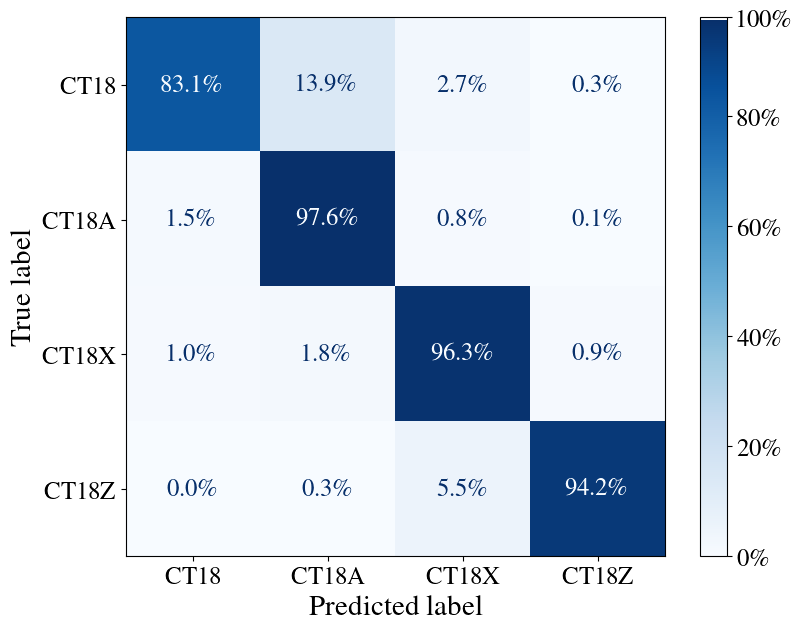

In [4]:
get_conf_matrix(x_test, y_test)

In [5]:
y_ints = y_test.astype(int)
index_list = np.zeros((4,int(len(y_ints)/4)), dtype=int)
for i in range(4):
    index_list[i] = np.where(np.nonzero(y_ints)[1]==i)[0]

In [6]:
xMax = 0.5
xMin = 1e-4
xFine = 200
num_flavors = 6
num_classes = 4
input_dim = 1200
load_model = PDFClassifier(input_dim, num_classes)
load_model.build(x_test.shape)
load_model.load_weights('rn.chkpnt.weights.h5')

psm_model = models.Model(inputs=load_model.layers[0].input,
                         outputs=load_model.layers[0].get_layer('dense_output').output)


grad_list = np.zeros((len(index_list[0]),num_flavors*xFine,4))
unnormalized_grads = np.zeros((len(index_list[0]),num_flavors*xFine,4))
indexed_x_test = x_test[index_list]

for set in range(len(indexed_x_test)):
    for k in range(len(indexed_x_test[0])):
        input_image = tf.convert_to_tensor(indexed_x_test[set,k].reshape(1,num_flavors*xFine))
        with tf.GradientTape() as tape:
            tape.watch(input_image)
            result = psm_model(input_image)
            max_score = result[0][tf.argmax(result,axis=1)[0]]
        grads = tape.gradient(max_score, input_image).numpy()
        unnormalized_grads[k,:,set] = grads.flatten()
        norm_grads = np.maximum(grads,0)/(grads.max()+1e-12)
        grad_list[k,:,set] = norm_grads.flatten()

In [ ]:
#Import the standard scaler model used to scale the training data
with open('pheno_class_scaler.pkl','rb') as f:
    sc = pickle.load(f)
    
x_test_reshape = sc.inverse_transform(x_test)

pdfs_by_set = x_test_reshape[index_list].T
pos_pdf_devs = np.zeros((num_flavors*xFine, 4))
neg_pdf_devs = np.zeros((num_flavors*xFine, 4))
mean_array = np.zeros((num_flavors*xFine,4))

for set in range(4):
    for x in range(num_flavors*xFine):
        replicas = pdfs_by_set[x,:,set]
        pos_reps = replicas[replicas > np.mean(replicas)]
        neg_reps = replicas[replicas < np.mean(replicas)]
        
        pos_pdf_devs[x,set] = np.std(pos_reps)
        neg_pdf_devs[x,set] = -np.std(neg_reps)
        
        mean_array[x,set] = np.mean(pdfs_by_set[x,:,set])

In [8]:
grad_stds = np.zeros((num_flavors*xFine,4))
padded_grad_stds = np.zeros((num_flavors*xFine+2,4))

for set in range(4):
    for k in range(num_flavors*xFine):
        grad_stds[k,set] = np.std(grad_list[:,k,set])
    grad_stds[:,set] = grad_stds[:,set]/np.max(grad_stds[:,set])
    padded_grad_stds[:,set] = np.pad(grad_stds[:,set], (1,1)) #prepare for smoothing via moving average

#moving average
def moving_average(arr, n):
    avarr = np.cumsum(arr, axis=0, dtype=float)
    avarr[n:] = avarr[n:] - avarr[:-n]
    return avarr[n - 1:] / n

avg_grad_stds = moving_average(padded_grad_stds,3)

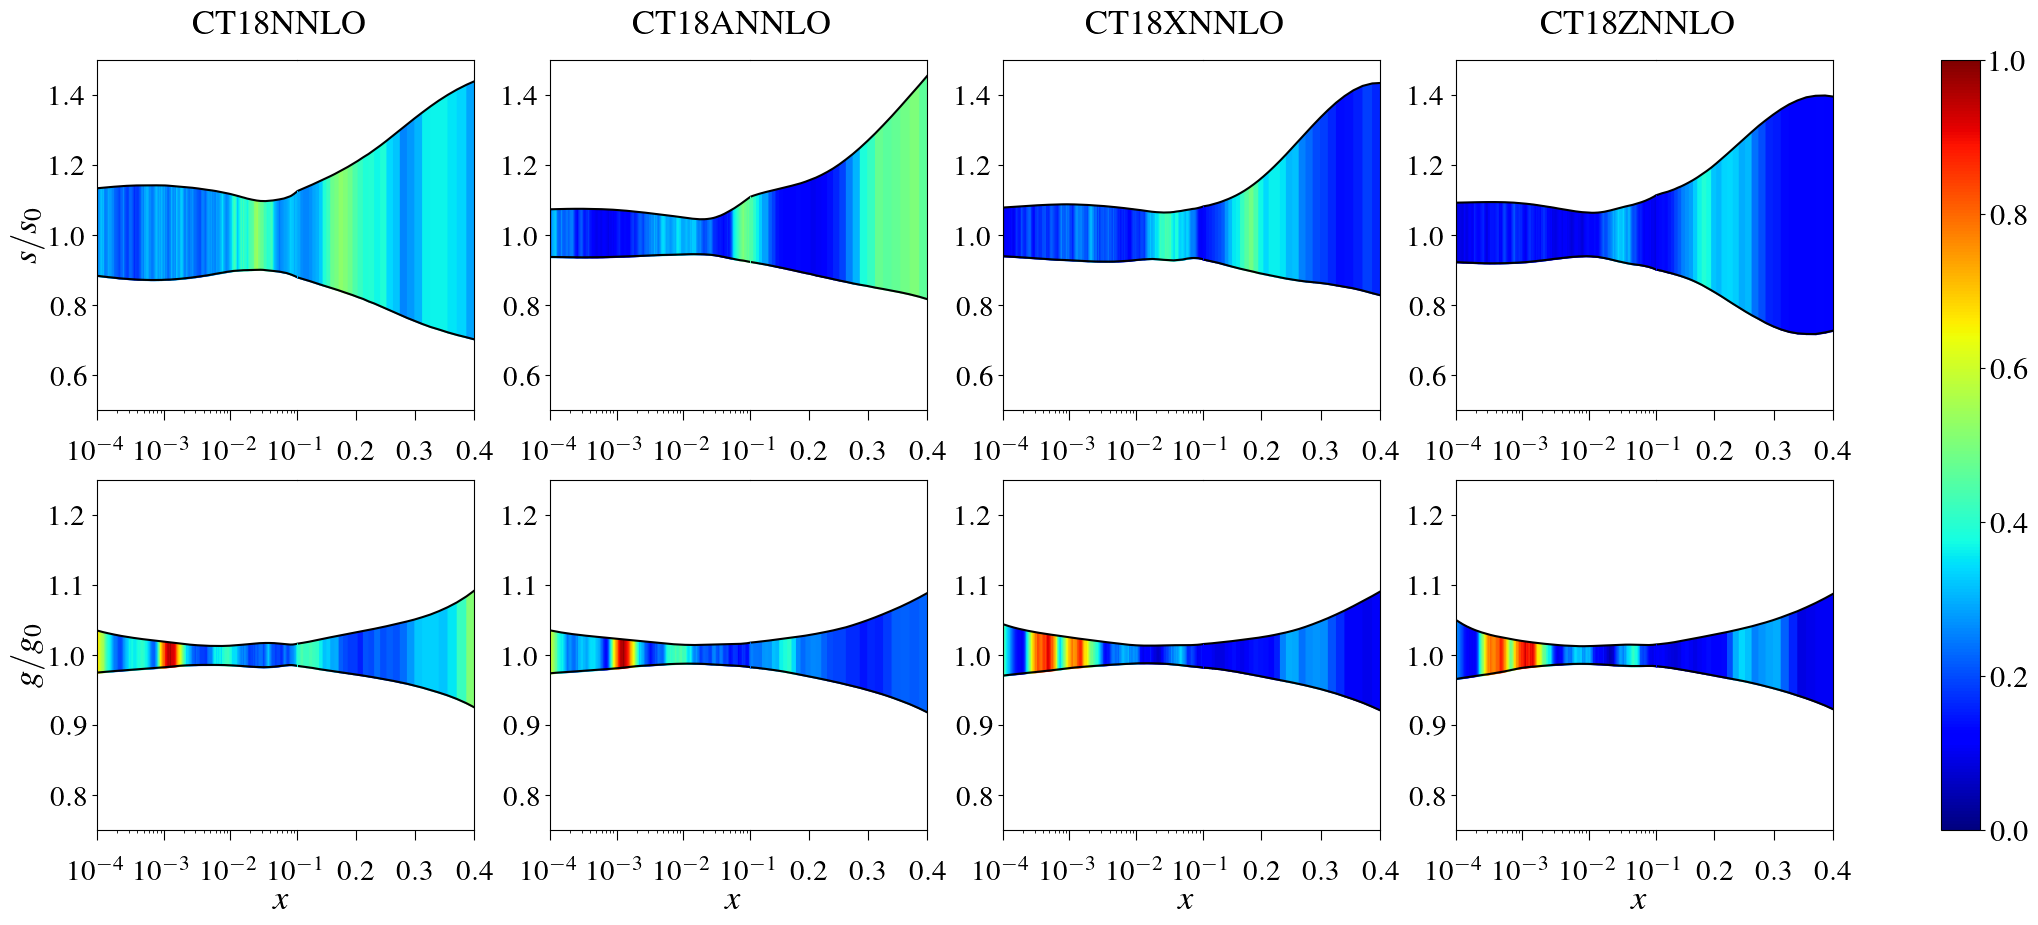

In [9]:
xs1 = np.logspace(np.log10(xMin),np.log10(xMax),xFine)
xs = np.logspace(np.log10(xMin),np.log10(xMax),num_flavors*xFine)

fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(28,10))
jet = mpl.colormaps['jet'].resampled(256)
plot_titles = ['CT18NNLO','CT18ANNLO','CT18XNNLO','CT18ZNNLO']

for set in range(len(indexed_x_test)):
    axMain = plt.subplot(2,4,set+1)
    axMain.plot(xs1, 
                mean_array[4*xFine:5*xFine,set] + pos_pdf_devs[4*xFine:5*xFine,set],
                c='black'
               )
    axMain.plot(xs1, 
                mean_array[4*xFine:5*xFine,set] + neg_pdf_devs[4*xFine:5*xFine,set],
                c='black'
               )
    for i in range(int(len(xs)/6)):
        axMain.fill_between(xs1[i:i+2], 
                            mean_array[4*xFine:5*xFine,set][i:i+2] + pos_pdf_devs[i+4*xFine:i+4*xFine+2,set], 
                            mean_array[4*xFine:5*xFine,set][i:i+2] + neg_pdf_devs[i+4*xFine:i+4*xFine+2,set],
                            color=jet(avg_grad_stds[i+4*xFine,set])
                           )

    plt.xticks(fontsize=21)
    axMain.set_xscale('linear')
    axMain.set_xlim((0.101, 0.4))
    axMain.set_xticks([0.2,0.3,0.4])
    axMain.spines['left'].set_visible(False)
    axMain.yaxis.set_ticks_position('right')
    axMain.yaxis.set_visible(False)

    divider = make_axes_locatable(axMain)
    axLin = divider.append_axes("left", size=2.0, pad=0, sharey=axMain)
    axLin.set_xscale('log')
    axLin.set_xlim((1e-4, 0.1))
    axLin.plot(xs1, 
               mean_array[4*xFine:5*xFine,set] + pos_pdf_devs[4*xFine:5*xFine,set],
               c='black')
    axLin.plot(xs1, 
               mean_array[4*xFine:5*xFine,set] + neg_pdf_devs[4*xFine:5*xFine,set],
               c='black')
    for i in range(int(len(xs)/6)):
        axLin.fill_between(xs1[i:i+2], 
                           mean_array[4*xFine:5*xFine,set][i:i+2] + pos_pdf_devs[i+4*xFine:i+4*xFine+2,set], 
                           mean_array[4*xFine:5*xFine,set][i:i+2] + neg_pdf_devs[i+4*xFine:i+4*xFine+2,set],
                           color=jet(avg_grad_stds[i+4*xFine,set])
                          )

    axLin.spines['right'].set_visible(False)
    axLin.yaxis.set_ticks_position('left')
    plt.setp(axLin.get_xticklabels(), visible=True)
    
    if set == 0:
        plt.ylabel(r'$s/s_0$',fontsize=25)
        
    plt.xticks(fontsize=21)
    axMain.annotate(plot_titles[set], 
                    xy=(-0.1, 1.1), 
                    xycoords='axes fraction', 
                    fontsize=25, 
                    ha='center', 
                    va='center')

    plt.yticks(fontsize=21)

    axMain.tick_params(axis='x', which='major', pad=14, length = 7)
    axLin.tick_params(axis='x', which='major', pad=14, length = 7)
    plt.ylim(0.5,1.5)

for set in range(len(indexed_x_test)):

    axMain = plt.subplot(2,4,4 + set+1)
    axMain.plot(xs1, 
                mean_array[5*xFine:6*xFine,set] + pos_pdf_devs[5*xFine:6*xFine,set],
                c='black'
               )
    axMain.plot(xs1, 
                mean_array[5*xFine:6*xFine,set] + neg_pdf_devs[5*xFine:6*xFine,set],
                c='black'
               )
    for i in range(int(len(xs)/6)):
        axMain.fill_between(xs1[i:i+2],
                            mean_array[5*xFine:6*xFine,set][i:i+2] + pos_pdf_devs[i+5*xFine:i+5*xFine+2,set], 
                            mean_array[5*xFine:6*xFine,set][i:i+2] + neg_pdf_devs[i+5*xFine:i+5*xFine+2,set],
                            color=jet(avg_grad_stds[i+5*xFine,set])
                           )

    plt.xticks(fontsize=21)
    axMain.set_xscale('linear')
    axMain.set_xlim((0.101, 0.4))
    axMain.set_xticks([0.2,0.3,0.4])
    axMain.spines['left'].set_visible(False)
    axMain.yaxis.set_ticks_position('right')
    axMain.yaxis.set_visible(False)

    divider = make_axes_locatable(axMain)
    axLin = divider.append_axes("left", size=2.0, pad=0, sharey=axMain)
    axLin.set_xscale('log')
    axLin.set_xlim((1e-4, 0.1))
    axLin.plot(xs1, 
               mean_array[5*xFine:6*xFine,set] + pos_pdf_devs[5*xFine:6*xFine,set],
               c='black'
              )
    axLin.plot(xs1,
               mean_array[5*xFine:6*xFine,set] + neg_pdf_devs[5*xFine:6*xFine,set],
               c='black'
              )
    for i in range(int(len(xs)/6)):
        axLin.fill_between(xs1[i:i+2], 
                           mean_array[5*xFine:6*xFine,set][i:i+2] + pos_pdf_devs[i+5*xFine:i+5*xFine+2,set], 
                           mean_array[5*xFine:6*xFine,set][i:i+2] + neg_pdf_devs[i+5*xFine:i+5*xFine+2,set],
                           color=jet(avg_grad_stds[i+5*xFine,set])
                          )

    axLin.spines['right'].set_visible(False)
    axLin.yaxis.set_ticks_position('left')
    plt.setp(axLin.get_xticklabels(), visible=True)
    
    plt.xticks(fontsize=21)

    plt.yticks(fontsize=21)

    axMain.tick_params(axis='x', which='major', pad=14, length = 7)
    axLin.tick_params(axis='x', which='major', pad=14, length = 7)
    

    if set == 0:
        plt.ylabel(r'$g/g_0$',fontsize=25)

    plt.ylim(0.75, 1.25)

    axMain.annotate(r'$x$', xy=(-0.1, -0.2), xycoords='axes fraction', fontsize=25, ha='center', va='center')

norm = mcolors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax.ravel().tolist(), orientation='vertical')
#cbar.set_label('Gradient Mean Smoothing', fontsize=18)
cbar.ax.tick_params(labelsize=22)

plt.savefig('pheno_saliency_map.pdf', format = 'pdf')
plt.show()